In [1]:
# Import Modules and functions
# ----------------------------
from Functions import *
from Modules   import *

In [2]:
df    = pd.read_csv('..\\Data\\data_train.csv')
X_aim = pd.read_csv('..\\Data\\features_aim.csv')
# --- Clean and prepare data and Aim -----

X_train, X_test, y_train, y_test, X_aim = CLEAN_All_DATA(df, X_aim)

### Base Decision Tree Model with Max_depth = 1

In [3]:
# Instantiate DT model
preprocessor     = ColumnTransformer([('num', 'passthrough', num_cols),
                                      ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
                                      ])

# The classifier:
model_DT         = DecisionTreeClassifier(max_depth    = 1, 
                                          class_weight = 'balanced', 
                                          random_state = 42)

pipeline_DT_base = Pipeline([('preprocessor', preprocessor),
                             ('DTClassifier', model_DT)
                            ])

In [4]:

pipeline_DT_base.fit(X_train, y_train)
# --------------------------------------------------------------------
pred_DT_base      = pipeline_DT_base.predict(X_test)
f1_DT_base        = f1_score(y_test, pred_DT_base)
recall_DT_base    = recall_score(y_test, pred_DT_base)
precision_DT_base = precision_score(y_test, pred_DT_base)
accuracy_DT_base  = accuracy_score(y_test, pred_DT_base)

DT_metrics        = pd.DataFrame({
                                 'Model'    : ['logistic Regression'],
                                 'F1 Score' : [f1_DT_base],
                                 'Recall'   : [recall_DT_base],
                                 'Precision': [precision_DT_base],
                                 'Accuracy' : [accuracy_DT_base]
                                })

### Decision Tree Plot

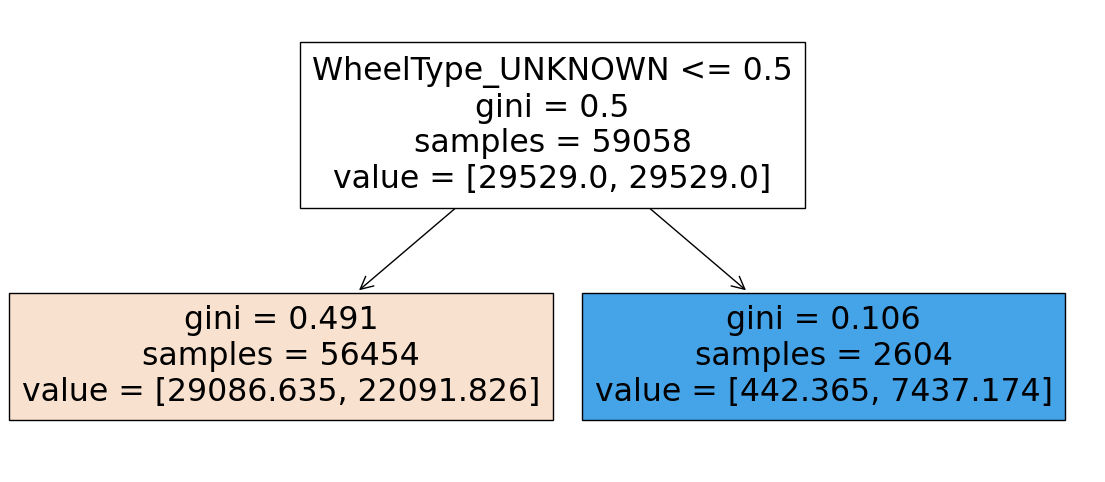

In [5]:

fitted_tree = pipeline_DT_base.named_steps['DTClassifier']                # Extracting the DT from pipeline

# Feature names 
ohe         = (pipeline_DT_base.named_steps['preprocessor']               # Extracting the OneHotEncoder
                       .named_transformers_['cat'])                                 
cat_feature_names = ohe.get_feature_names_out(input_features = cat_cols)  # Getting OH encoded feature names
feature_names     = num_cols + list(cat_feature_names)                    # Concatenating with numerical feature names

#  ---------------------------------------------------------------------------------------------------------------
plt.figure(figsize      = (14,6))  
plot_tree(decision_tree = fitted_tree,
          feature_names = feature_names,
          filled        = True);

Scoring of DT Classifier


Model,F1 Score,Recall,Precision,Accuracy
logistic Regression,0.347982,0.229314,0.721190,0.889211


-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


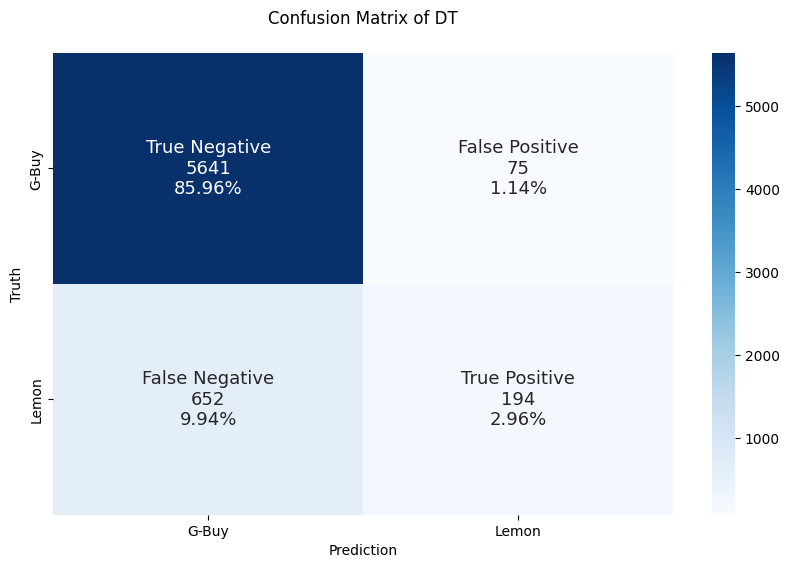

In [6]:
print('Scoring of DT Classifier')
# -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- --
display(DT_metrics.style.hide())
print('-- '*30)
Confusion_Matrix_Func(y_test, pred_DT_base, 'DT')

In [7]:
scoring = {'f1'       : 'f1',
           'recall'   : 'recall',
           'precision': 'precision',
           'accuracy' : 'accuracy'}

scores = []
# Iterate through each parameter, fit model, and store metrics
for i in range(1, 8):
    pipeline_DT_base.set_params(DTClassifier__max_depth = i)
    
    cv_results    = cross_validate(pipeline_DT_base, 
                                   X_train, 
                                   y_train, 
                                   scoring = scoring, 
                                   cv      = 5)
    
    pipeline_DT_base.fit(X_train, y_train)
    pred_grid      = pipeline_DT_base.predict(X_test)
    
    f1_test        = f1_score(y_test, pred_grid)
    recall_test    = recall_score(y_test, pred_grid)
    precision_test = precision_score(y_test, pred_grid)
    accuracy_test  = accuracy_score(y_test, pred_grid)
    
    scores.append({'Max_depth'     : i,
                   'Val f1'        : cv_results['test_f1'].mean(),
                   'Val recall'    : cv_results['test_recall'].mean(),
                   'Val Precision' : cv_results['test_precision'].mean(),
                   'Val_accuracy'  : cv_results['test_accuracy'].mean(),
                   'Test f1'       : f1_test,
                   'Test recall'   : recall_test,
                   'Test precision': precision_test,
                   'Test accuracy' : accuracy_test})

pd.DataFrame(scores).style.hide()


Max_depth,Val f1,Val recall,Val Precision,Val_accuracy,Test f1,Test recall,Test precision,Test accuracy
1,0.370649,0.251858,0.702071,0.894917,0.347982,0.229314,0.721190,0.889211
2,0.320118,0.594794,0.219618,0.688509,0.330179,0.598109,0.228031,0.687138
3,0.373288,0.421877,0.335408,0.825697,0.376172,0.403073,0.352637,0.827644
4,0.357112,0.515853,0.279224,0.767380,0.368514,0.495272,0.293417,0.781164
5,0.365848,0.500689,0.288863,0.786498,0.364660,0.497636,0.287765,0.776440
6,0.356100,0.533747,0.270089,0.761269,0.371823,0.492908,0.298497,0.785279
7,0.339668,0.623599,0.236131,0.698871,0.349025,0.613475,0.243891,0.704968


### GridSearch for Decision Tree Model

In [8]:

preprocessor   = ColumnTransformer([('num', 'passthrough', num_cols),
                                    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
                                   ])

model_Tree     = DecisionTreeClassifier(random_state=42)

pipeline_Tree  = Pipeline([('preprocessor', preprocessor),
                           ('DTClassifier' , model_Tree)
                         ])

param_grid    = {'DTClassifier__max_depth'        : [22,23,24,25],  
                 'DTClassifier__min_samples_split': [5, 6, 7],  
                 'DTClassifier__min_samples_leaf' : [1, 2]
                }

scoring       = {'accuracy': make_scorer(accuracy_score),
                 'recall'  : make_scorer(recall_score),
                 'f1'      : make_scorer(f1_score)
                }

model_dt_grid = GridSearchCV(pipeline_Tree, 
                             param_grid         = param_grid, 
                             cv                 = 3, 
                             scoring            = 'f1', # or --> scoring,
                           # refit              = 'f1',
                             n_jobs             = 8, 
                             return_train_score = True
                            )


In [9]:
model_dt_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['MMRAcquisitionAuctionAveragePrice',
                                                                          'MMRAcquisitionAuctionCleanPrice',
                                                                          'MMRAcquisitionRetailAveragePrice',
                                                                          'MMRAcquisitonRetailCleanPrice',
                                                                          'MMRCurrentAuctionAveragePrice',
                                                                          'MMRCurrentAuctionCleanPrice',
                                                                          'MMRCurrentRetailAveragePrice',
                                                                          'MMRCu...
                                                                          'IsOnlineSale',
                                                                          'PRIMEUNIT',
                                                                          'AUCGUART',
                                                                          'BYRNO',
                                                                          'VNZIP1',
                                                                          'VNST',
                                                                          'PurchDate_year',
                                                                          'PurchDate_month',
                                                                          'PurchDate_dayofweek'])])),
                                       ('DTClassifier',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=8,
             param_grid={'DTClassifier__max_depth': [22, 23, 24, 25],
                         'DTClassifier__min_samples_leaf': [1, 2],
                         'DTClassifier__min_samples_split': [5, 6, 7]},
             return_train_score=True, scoring='f1')

In [10]:

optimised_dt_grid   = model_dt_grid.best_estimator_
optimised_dt_params = model_dt_grid.best_params_



# Evaluate the model:
pred_dt_grid       = model_dt_grid.predict(X_test)
f1_dt_grid         = f1_score(y_test       , pred_dt_grid)
recall_dt_grid     = recall_score(y_test   , pred_dt_grid)
precision_dt_grid  = precision_score(y_test, pred_dt_grid)
accuracy_dt_grid   = accuracy_score(y_test , pred_dt_grid)


grid_DT_metrics    = pd.DataFrame({
                                    'Model'    : ['GridSearch Optimised DT'],
                                    'F1 Score' : [f1_dt_grid],
                                    'Recall'   : [recall_dt_grid],
                                    'Precision': [precision_dt_grid],
                                    'Accuracy' : [accuracy_dt_grid]
                                    })
# Use with scoring
# results = model_dt_grid.cv_results_
# print("With best parameters, cross-validated accuracy: {:.2f}"\
#       .format(results['mean_test_accuracy'][model_dt_grid.best_index_]))
# print("With best parameters, cross-validated recall: {:.2f}"\
#       .format(results['mean_test_recall'][model_dt_grid.best_index_]))
# print("Highest cross-validated F1 score: {:.2f}".format(model_dt_grid.best_score_))

In [11]:
print('Scoring of GridSearch Optimised LR Classifier')
print('Optimised DT Model:'     , optimised_dt_grid)
print('-- '*30)
print("Optimised DT Parameters:", optimised_dt_params)

Scoring of GridSearch Optimised LR Classifier
Optimised DT Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['MMRAcquisitionAuctionAveragePrice',
                                                   'MMRAcquisitionAuctionCleanPrice',
                                                   'MMRAcquisitionRetailAveragePrice',
                                                   'MMRAcquisitonRetailCleanPrice',
                                                   'MMRCurrentAuctionAveragePrice',
                                                   'MMRCurrentAuctionCleanPrice',
                                                   'MMRCurrentRetailAveragePrice',
                                                   'MMRCurrentRetailCleanPrice',
                                                   'VehB...
                                                  ['Auction', 'VehicleAge',
                  

Scoring of GridSearch Optimised DT


Model,F1 Score,Recall,Precision,Accuracy
GridSearch Optimised DT,0.358653,0.270686,0.531323,0.875190


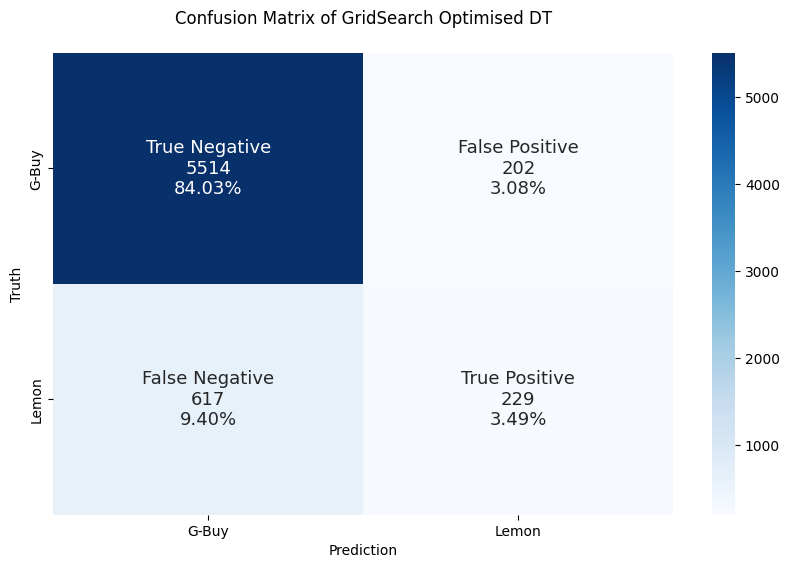

In [12]:
print('Scoring of GridSearch Optimised DT')
display(grid_DT_metrics.style.hide())
Confusion_Matrix_Func(y_test, pred_dt_grid, 'GridSearch Optimised DT')

### Save the optimised DT model

In [14]:
# Save the model as it is quite demanding

directory_path = r"D:\Visual Studio Code\Used Cars Sales\Pickle"
filename = "optimised_GridSearch_DT.p"

pickle.dump(model_dt_grid, open(directory_path + "\\" + filename, "wb"))

## Random Forests

### Simple RF model

In [18]:
# The whole pipeline
preprocessor  = ColumnTransformer([('num', 'passthrough', num_cols),
                                   ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)])

# The classifier:
rfc           = RandomForestClassifier(class_weight      = 'balanced', 
                                       random_state      = 42, 
                                       n_estimators      = 100, 
                                       max_depth         = 27,
                                       min_samples_split = 7,
                                       min_samples_leaf  = 3)

model_rfc  = Pipeline([('preprocessor', preprocessor),
                       ('rfClassifier', rfc)
                     ])

In [21]:
model_rfc.fit(X_train, y_train)

pred_rfc        = model_rfc.predict(X_test)
f1_rfc          = f1_score(y_test, pred_rfc)
recall_rfc      = recall_score(y_test, pred_rfc)
precision_rfc   = precision_score(y_test, pred_rfc)
accuracy_rfc    = accuracy_score(y_test, pred_rfc)

grid_DT_metrics = pd.DataFrame({
                                'Model'    : ['Model RF'],
                                'F1 Score' : [f1_rfc],
                                'Recall'   : [recall_rfc],
                                'Precision': [precision_rfc],
                                'Accuracy' : [accuracy_rfc]
                              })

Scoring of RF


Model,F1 Score,Recall,Precision,Accuracy
Model RF,0.409820,0.483452,0.355652,0.820482


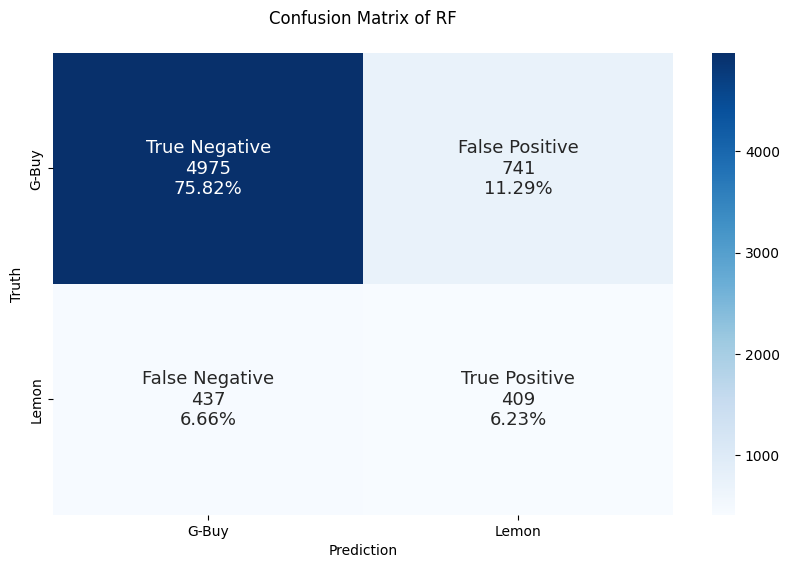

In [24]:
print('Scoring of RF')
display(grid_DT_metrics.style.hide())
Confusion_Matrix_Func(y_test, pred_rfc, 'RF')

#### RF GridSearch Without PCA and or Polynomial 

In [70]:

# RF GridSearch Without PCA and or Polynomial 

# num_pipeline = Pipeline([('poly'  , PolynomialFeatures(degree=2)),
#                          ('scaler', StandardScaler()),
#                          ('pca'   , PCA(n_components=.991))
#                         ])

preprocessor     = ColumnTransformer([
                                      ('num', 'passthrough', num_cols),
                                      ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
                                    ])

rfc              = RandomForestClassifier(class_weight         = 'balanced',
                                          random_state         = 442, 
                                          #  n_estimators      = 80,
                                          #  max_features      = 59,
                                          #  max_depth         = 36,
                                          #  min_samples_leaf  = 2,    
                                          #  min_samples_split = 9
                                         )

pipeline_rfc     = Pipeline([('preprocessor', preprocessor),
                             ('rfClassifier', rfc)
                            ])

param_grid       = {
                   'rfClassifier__n_estimators'     : [87, 88, 89],  
                   'rfClassifier__max_depth'        : [35, 36, 37],  
                   'rfClassifier__min_samples_leaf' : [2 , 3 , 4 ],     
                   'rfClassifier__min_samples_split': [9 , 10, 11],     
                   }
model_rfc_grid   = GridSearchCV(estimator    = pipeline_rfc, 
                                param_grid   = param_grid, 
                                scoring      = 'f1', 
                                cv           = 3,  
                                n_jobs       = 8
                                )

In [71]:
model_rfc_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['MMRAcquisitionAuctionAveragePrice',
                                                                          'MMRAcquisitionAuctionCleanPrice',
                                                                          'MMRAcquisitionRetailAveragePrice',
                                                                          'MMRAcquisitonRetailCleanPrice',
                                                                          'MMRCurrentAuctionAveragePrice',
                                                                          'MMRCurrentAuctionCleanPrice',
                                                                          'MMRCurrentRetailAveragePrice',
                                                                          'MMRCu...
                                                                          'VNST',
                                                                          'PurchDate_year',
                                                                          'PurchDate_month',
                                                                          'PurchDate_dayofweek'])])),
                                       ('rfClassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=442))]),
             n_jobs=8,
             param_grid={'rfClassifier__max_depth': [35, 36, 37],
                         'rfClassifier__min_samples_leaf': [2, 3, 4],
                         'rfClassifier__min_samples_split': [9, 10, 11],
                         'rfClassifier__n_estimators': [87, 88, 89]},
             scoring='f1')

In [72]:

optimised_rfc_grid   = model_rfc_grid.best_estimator_
optimised_rfc_params = model_rfc_grid.best_params_
pred_rfc_grid        = model_rfc_grid.predict(X_test) 

f1_rfc_grid            = f1_score(y_test       , pred_rfc_grid)
recall_rfc_grid        = recall_score(y_test   , pred_rfc_grid)
precision_rfc_grid     = precision_score(y_test, pred_rfc_grid)
accuracy_rfc_grid      = accuracy_score(y_test , pred_rfc_grid)


grid_rfc_metrics    = pd.DataFrame({
                                    'Model'    : ['GridSearch Optimised RFC'],
                                    'F1 Score' : [f1_rfc_grid],
                                    'Recall'   : [recall_rfc_grid],
                                    'Precision': [precision_rfc_grid],
                                    'Accuracy' : [accuracy_rfc_grid]
                                    })

In [73]:
print('Scoring of GridSearch Optimised RF Classifier')
print('Optimised RFC Model:'    , optimised_rfc_grid)
print('Optimised RFC Parameters:', optimised_rfc_params)

Scoring of GridSearch Optimised RF Classifier
Optimised RFC Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['MMRAcquisitionAuctionAveragePrice',
                                                   'MMRAcquisitionAuctionCleanPrice',
                                                   'MMRAcquisitionRetailAveragePrice',
                                                   'MMRAcquisitonRetailCleanPrice',
                                                   'MMRCurrentAuctionAveragePrice',
                                                   'MMRCurrentAuctionCleanPrice',
                                                   'MMRCurrentRetailAveragePrice',
                                                   'MMRCurrentRetailCleanPrice',
                                                   'VehB...
                                                   'SubModel', 'Color',
                     

Scoring of GridSearch RF


Model,F1 Score,Recall,Precision,Accuracy
GridSearch Optimised RFC,0.420455,0.393617,0.451220,0.860104


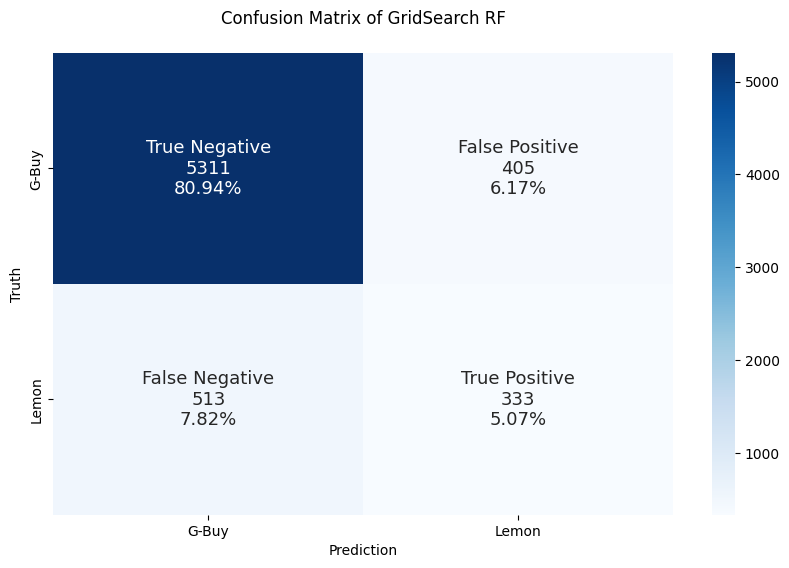

In [74]:
print('Scoring of GridSearch RF')
display(grid_rfc_metrics.style.hide())
Confusion_Matrix_Func(y_test, pred_rfc_grid, 'GridSearch RF')

In [76]:
directory_path = r"D:\Visual Studio Code\Used Cars Sales\Pickle"
filename       = "Optimised_GridSearch_RFC_noPCA_noPOLY.p"

# Save to the specified directory
pickle.dump(optimised_rfc_grid, open(directory_path + "\\" + filename, "wb"))

#### RF GridSearch With PCA/Polynomial 

In [79]:

# RF GridSearch Without PCA and or Polynomial 

poly_pca_pipe             = Pipeline([('poly'  , PolynomialFeatures(degree=2)),
                                      ('scaler', StandardScaler()),
                                      ('pca'   , PCA(n_components=.991))
                                    ])

preprocessor              = ColumnTransformer([
                                              ('num', poly_pca_pipe, num_cols),
                                              ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
                                              ])

rfc                       = RandomForestClassifier(class_weight         = 'balanced',
                                                   random_state         = 442, 
                                                   #  n_estimators      = 80,
                                                   #  max_features      = 59,
                                                   #  max_depth         = 36,
                                                   #  min_samples_leaf  = 2,    
                                                   #  min_samples_split = 9
                                                 )

pipeline_rfc_poly_pca     = Pipeline([('preprocessor', preprocessor),
                                      ('rfClassifier', rfc)
                                    ])

param_grid                = {
                            'rfClassifier__n_estimators'     : [87, 88, 89],  
                            'rfClassifier__max_depth'        : [35, 36, 37],  
                            'rfClassifier__min_samples_leaf' : [2 , 3 , 4 ],     
                            'rfClassifier__min_samples_split': [9 , 10, 11],     
                            }
model_rfc_poly_pca_grid   = GridSearchCV(estimator    = pipeline_rfc_poly_pca, 
                                         param_grid   = param_grid, 
                                         scoring      = 'f1', 
                                         cv           = 3,  
                                         n_jobs       = 8
                                         )

In [80]:
model_rfc_poly_pca_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA(n_components=0.991))]),
                                                                         ['MMRAcquisitionAuctionAveragePrice',
                                                                          'MMRAcquisitionAuctionCleanPrice',
                                                                          'MMRAcquisitionRetailAveragePrice',
                                                                          'MMRAcquisitonRetailCleanPrice',
                                                                          'MMRC...
                                                                          'VNST',
                                                                          'PurchDate_year',
                                                                          'PurchDate_month',
                                                                          'PurchDate_dayofweek'])])),
                                       ('rfClassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=442))]),
             n_jobs=8,
             param_grid={'rfClassifier__max_depth': [35, 36, 37],
                         'rfClassifier__min_samples_leaf': [2, 3, 4],
                         'rfClassifier__min_samples_split': [9, 10, 11],
                         'rfClassifier__n_estimators': [87, 88, 89]},
             scoring='f1')

In [84]:
optimised_rfc_poly_pca_grid   = model_rfc_poly_pca_grid.best_estimator_
optimised_rfc_poly_pca_params = model_rfc_poly_pca_grid.best_params_
pred_rfc_poly_pca_grid        = model_rfc_poly_pca_grid.predict(X_test) 

f1_rfc_poly_pca_grid            = f1_score(y_test       , pred_rfc_poly_pca_grid)
recall_rfc_poly_pca_grid        = recall_score(y_test   , pred_rfc_poly_pca_grid)
precision_rfc_poly_pca_grid     = precision_score(y_test, pred_rfc_poly_pca_grid)
accuracy_rfc_poly_pca_grid      = accuracy_score(y_test , pred_rfc_poly_pca_grid)


grid_rfc_poly_pca_metrics      = pd.DataFrame({
                                            'Model'    : ['GridSearch Optimised RFC with POLY/PCA'],
                                            'F1 Score' : [f1_rfc_poly_pca_grid],
                                            'Recall'   : [recall_rfc_poly_pca_grid],
                                            'Precision': [precision_rfc_poly_pca_grid],
                                            'Accuracy' : [accuracy_rfc_poly_pca_grid]
                                            })

In [85]:
print('Scoring of GridSearch Optimised LR Classifier')
print('Optimised RFC POLY/PCA Model:'     , optimised_rfc_poly_pca_grid)
print("Optimised RFC POLY/PCA Parameters:", optimised_rfc_poly_pca_params)

Scoring of GridSearch Optimised LR Classifier
Optimised RFC POLY/PCA Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.991))]),
                                                  ['MMRAcquisitionAuctionAveragePrice',
                                                   'MMRAcquisitionAuctionCleanPrice',
                                                   'MMRAcquisitionRetailAveragePrice',
                                                   'MMRAcquisitonRetailClean

Scoring of GridSearch RF


Model,F1 Score,Recall,Precision,Accuracy
GridSearch Optimised RFC with POLY/PCA,0.424574,0.412530,0.437343,0.855837


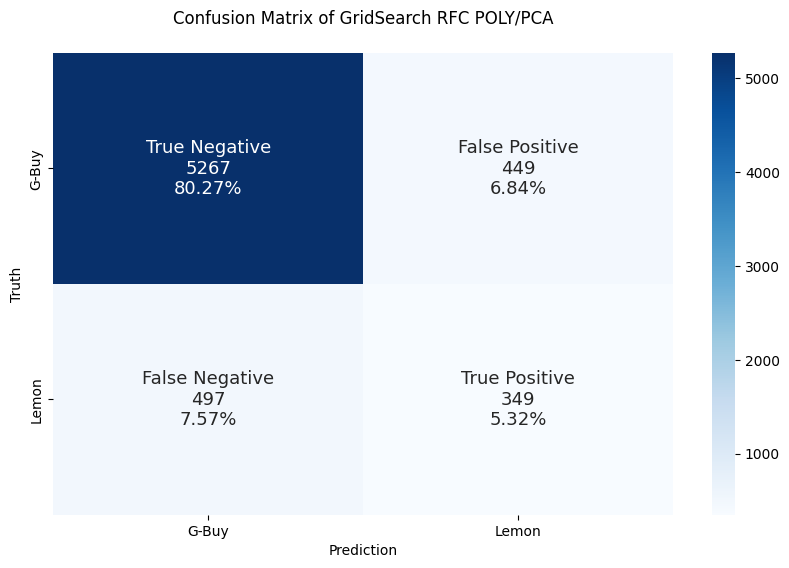

In [87]:
print('Scoring of GridSearch RF')
display(grid_rfc_poly_pca_metrics.style.hide())
Confusion_Matrix_Func(y_test, pred_rfc_poly_pca_grid, 'GridSearch RFC POLY/PCA')

In [88]:
directory_path = r"D:\Visual Studio Code\Used Cars Sales\Pickle"
filename       = "Optimised_GridSearch_RFC_PCA_POLY.p"

# Save to the specified directory
pickle.dump(optimised_rfc_poly_pca_grid, open(directory_path + "\\" + filename, "wb"))